In [1]:
import math

from typing import Optional, List, Tuple

from collections import OrderedDict

import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm as tqdm_auto
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl

In this tutorial, it is shown how to use the PARADE neural network for training on new data from scratch.

### Defining PARADE infrastructure

In the following cells, PARADE infrastructural code is defined, as PyTorch Dataset class and additional classes required for sequence string encoding.

In [2]:
class Seq2Tensor(nn.Module):
    CODES = {
        "A": 0,
        "C": 1,
        "G": 2,
        "T": 3,
        "N": 4,
    }

    def __init__(self):
        super().__init__()

    @staticmethod
    def n2id(n):
        return Seq2Tensor.CODES[n]

    def forward(self, seq):
        seq = [self.n2id(x) for x in seq.upper()]
        code = torch.tensor(seq)
        code = F.one_hot(code, num_classes=5)

        code[code[:, 4] == 1] = 0.25
        code = code[:, :4].float()
        return code.transpose(0, 1)

In [3]:
class Condition2Tensor(nn.Module):
    def __init__(self, num_conditions, condition_codes):
        super().__init__()
        self.num_conditions = num_conditions
        self.condition_codes = condition_codes

    def forward(self, condition):
        code = self.condition_codes[condition]
        code = torch.tensor(code)
        code = F.one_hot(code, num_classes=self.num_conditions)

        return code.float()

In [4]:
class SequenceData(torch.utils.data.Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        seq_col: str = "seq",
        predict_cols: Optional[List[str]] = None,
        condition_col: Optional[str] = None,
        conditions: Optional[List[str] | Tuple[str]] = None,
    ):
        """
        :param: df (pandas.DataFrame): a DataFrame that contains necessary information
        :param: seq_col (str): name of the column in `df` with sequence strings
        :param: predict_cols (List[str]): list of column names in `df` with target variables
        :param: condition_col (Optional[str]): name of the column in `df` with conditional
                variable that is added to input
        :param: conditions (Optional[List]): list of all possible conditions for `condition_col`
        """
        self.data = df
        self.seq_col = seq_col
        self.yield_targets = (predict_cols is not None)
        if self.yield_targets:
            self.predict_cols = predict_cols
        self.use_conditions = (condition_col is not None)
        if self.use_conditions:
            self.condition_col = condition_col
            self.condition_codes = {code: i for i, code in enumerate(conditions)}
            self.num_conditions = len(self.condition_codes)

        # Data preparation
        self.s2t = Seq2Tensor()
        if self.use_conditions:
            self.c2t = Condition2Tensor(num_conditions=self.num_conditions, condition_codes=self.condition_codes)

        self.prepare_data(df)

    def prepare_data(self, df: pd.DataFrame):
        self.features = ['sequence']
        self.seqs = df[self.seq_col]
        if self.yield_targets:
            self.targets = df[self.predict_cols].to_numpy(dtype=np.float32)
        if self.use_conditions:
            self.conditions = df[self.condition_col]
            self.features.append('conditions')

    def get_num_channels(self):
        if self.use_conditions:
            return 4 + self.num_conditions
        else:
            return 4

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        channel_groups = dict()
        seq = self.s2t(self.seqs.iloc[index])
        channel_groups['sequence'] = seq

        if self.use_conditions:
            condition = self.c2t(self.conditions.iloc[index])
            condition_chs = condition[:, None].broadcast_to((condition.shape[0], seq.shape[-1]))
            channel_groups['conditions'] = condition_chs

        to_concat = [channel_groups[k] for k in self.features]
        compiled_seq = torch.concat(to_concat)

        if self.yield_targets:
            targets = self.targets[index]
            return (compiled_seq, targets)
        else:
            return (compiled_seq,)

Here, the neural network classes are defined:

In [5]:
class SELayer(nn.Module):
    """
    Squeeze-and-Excite layer.
    Parameters
    ----------
    inp : int
        Middle layer size.
    oup : int
        Input and ouput size.
    reduction : int, optional
        Reduction parameter. The default is 4.
    """

    def __init__(self, inp, oup, reduction=4):
        super(SELayer, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(oup, int(inp // reduction)),
            nn.SiLU(),
            nn.Linear(int(inp // reduction), oup),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc(y).view(b, c, 1)
        return x * y

In [6]:
class LegNetModule(nn.Module):
    __constants__ = ('ks', 'resize_factor')

    def __init__(
        self,
        in_channels: int = 4,
        out_channels: int = 1,
        conv_sizes: Tuple[int] = (128, 64, 64, 32, 32),
        mapper_size: int = 128,
        linear_sizes: Optional[Tuple[int]] = (64,),
        ks: int = 5,
        resize_factor: int = 4,
        use_max_pooling: bool = False,
        activation: nn.Module = nn.SiLU,
        final_activation: nn.Module = nn.Identity,
        filter_per_group: int = 2,
        se_reduction: int = 4,
        bn_momentum: float = 0.1
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv_sizes = conv_sizes
        self.mapper_size = mapper_size
        self.linear_sizes = linear_sizes
        self.resize_factor = resize_factor
        self.use_max_pooling = use_max_pooling
        self.se_reduction = se_reduction
        self.bn_momentum = bn_momentum
        seqextblocks = OrderedDict()

        block = nn.Sequential(
            nn.Conv1d(
                in_channels=self.in_channels,
                out_channels=self.conv_sizes[0],
                kernel_size=ks,
                padding='same',
                bias=False
            ),
            nn.BatchNorm1d(self.conv_sizes[0],
                           momentum=self.bn_momentum),
            activation()
        )
        seqextblocks['blc0'] = block

        for ind, (prev_sz, sz) in enumerate(zip(self.conv_sizes[:-1], self.conv_sizes[1:])):
            block = nn.Sequential(
                nn.Conv1d(
                    in_channels=prev_sz,
                    out_channels=sz * self.resize_factor,
                    kernel_size=1,
                    padding='same',
                    bias=False
                ),
                nn.BatchNorm1d(sz * self.resize_factor,
                               momentum=self.bn_momentum),
                activation(),

                nn.Conv1d(
                    in_channels=sz * self.resize_factor,
                    out_channels=sz * self.resize_factor,
                    kernel_size=ks,
                    groups=sz * self.resize_factor // filter_per_group,
                    padding='same',
                    bias=False
                ),
                nn.BatchNorm1d(sz * self.resize_factor,
                               momentum=self.bn_momentum),
                activation(),
                SELayer(prev_sz, sz * self.resize_factor, reduction=self.se_reduction),
                nn.Conv1d(
                    in_channels=sz * self.resize_factor,
                    out_channels=prev_sz,
                    kernel_size=1,
                    padding='same',
                    bias=False
                ),
                nn.BatchNorm1d(prev_sz,
                               momentum=self.bn_momentum),
                activation(),
            )
            seqextblocks[f'inv_res_blc{ind}'] = block
            block = nn.Sequential(
                nn.Conv1d(
                    in_channels=2 * prev_sz,
                    out_channels=sz,
                    kernel_size=ks,
                    padding='same',
                    bias=False
                ),
                nn.BatchNorm1d(sz,
                               momentum=self.bn_momentum),
                activation(),
            )
            seqextblocks[f'resize_blc{ind}'] = block

        if self.use_max_pooling:
            self.maxpooling = nn.MaxPool1d(kernel_size=2, stride=2)
        else:
            self.maxpooling = nn.Identity()

        self.seqextractor = nn.ModuleDict(seqextblocks)

        self.mapper = block = nn.Sequential(
            nn.Conv1d(
                in_channels=self.conv_sizes[-1],
                out_channels=self.mapper_size,
                kernel_size=1,
                padding='same',
            ),
        )

        self.avgpooling = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
        )

        if self.linear_sizes is not None:
            first_linear = nn.Sequential(
                nn.Dropout(0.1),
                nn.Linear(self.mapper_size, self.linear_sizes[0]),
                nn.BatchNorm1d(self.linear_sizes[0],
                               momentum=self.bn_momentum),
                activation()
            )

            linear_blocks = list()
            for prev_sz, sz in zip(self.linear_sizes[:-1], self.linear_sizes[1:]):
                block = nn.Sequential(
                    nn.Dropout(0.1),
                    nn.Linear(prev_sz, sz),
                    nn.BatchNorm1d(sz,
                                   momentum=self.bn_momentum),
                    activation()
                )
                linear_blocks.append(block)

            last_linear = nn.Sequential(
                nn.Linear(self.linear_sizes[-1], self.out_channels),
                final_activation()
            )

            self.linear = nn.Sequential(
                nn.Dropout(0.1),
                first_linear,
                *linear_blocks,
                last_linear,
            )
        else:
            self.linear = nn.Sequential(
                nn.Linear(self.mapper_size, self.out_channels),
                final_activation()
            )

    def feature_extractor(self, x):
        x = self.seqextractor['blc0'](x)

        for i in range(len(self.conv_sizes) - 1):
            x = torch.cat([x, self.seqextractor[f'inv_res_blc{i}'](x)], dim=1)
            x = self.seqextractor[f'resize_blc{i}'](x)
            x = self.maxpooling(x)
        return x

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.mapper(x)
        x = self.avgpooling(x)
        x = self.linear(x)
        return x

Here, the PyTorch-Lightning wrapper is defined

In [7]:
class LightningLegNet(pl.LightningModule):
    def __init__(
        self,
        # train_params=TRAIN_DEFAULTS.copy(),
        model_class: nn.Module,
        model_kws: dict,
        criterion_class: nn.Module = nn.BCEWithLogitsLoss,
        criterion_kws: Optional[dict] = None,
        optimizer_class: torch.optim.Optimizer = torch.optim.AdamW,
        optimizer_kws: Optional[dict] = dict(
            lr=0.01,
            weight_decay=0.1,
        ),
        lr_scheduler_class: torch.optim.lr_scheduler.LRScheduler = torch.optim.lr_scheduler.OneCycleLR,
        lr_scheduler_kws: Optional[dict] = dict(
            max_lr=0.01,
            steps_per_epoch=128,
            epochs=40,
            pct_start=0.3,
            three_phase=False,
            cycle_momentum=True
        ),
    ):
        super().__init__()
        self.save_hyperparameters()

        self.model_name = self.hparams.model_class.__name__
        self.model = self.hparams.model_class(**self.hparams.model_kws)
        self.model.apply(self.initialize_weights)

        if self.hparams.criterion_kws is None:
            self.criterion = self.hparams.criterion_class()
        else:
            self.criterion = self.hparams.criterion_class(**self.hparams.criterion_kws)

    @staticmethod
    def initialize_weights(m):
        if isinstance(m, nn.Conv1d):
            n = m.kernel_size[0] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2 / n))
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight.data, 1)
            nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.001)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

    def compute_loss(self, batch):
        seqs, real = batch
        pred = self.model(seqs)
        loss = self.criterion(pred, real)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.compute_loss(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss

    def predict_step(self, batch, batch_idx):
        seqs, *_ = batch
        pred = self.model(seqs)
        return pred

    def validation_step(self, batch, batch_idx):
        loss = self.compute_loss(batch)
        self.log("val_loss", loss, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = self.hparams.optimizer_class(
            self.model.parameters(),
            **self.hparams.optimizer_kws
        )
        # optimizer = Lion(model.parameters(), lr=max_lr, weight_decay=weight_decay)
        if self.hparams.lr_scheduler_class is None:
            return optimizer
        else:
            lr_scheduler = self.hparams.lr_scheduler_class(
                optimizer,
                **self.hparams.lr_scheduler_kws
            )
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "monitor": "val_loss",
                    "strict": True,
                    "name": self.hparams.lr_scheduler_class.__name__,
                },
            }

### Loading data

Here, two important NN training options are configured:

These options are defined in the same way as they were in predictor NN, but may require tuning for your data.

In [8]:
BATCH_SIZE = 1024
EPOCHS = 10

Load your train dataset and divide it into two distinct Pandas DataFrame's: one for training and one for validation.

In [9]:
df = pd.read_csv("./UTR3_zscores_replicateagg.csv")

In [10]:
splits = dict(tuple(df.groupby('fold')))
for split_df in splits.values():
    split_df.reset_index(drop=True, inplace=True)

train_df = splits["train"]
val_df = splits["val"]
test_df = splits["test"]

In [11]:
train_df.head(5)

,seq,cell_type,fold,1,2,3,4,mass_center,mass_center_mean,diff,zscore,mass_center_std
0,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAATTTCCATGGCTAACTA...,c1,train,6.809279,5.843161,5.836944,23.948600,3.105728,2.860766,0.244962,1.165330,0.210208
1,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAATTTCCATGGCTAACTA...,c13,train,42.009822,34.532234,32.334772,56.966098,2.628650,2.860766,-0.232116,-1.104220,0.210208
2,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAATTTCCATGGCTAACTA...,c17,train,50.033644,45.049730,54.291393,110.129539,2.865176,2.860766,0.004410,0.020978,0.210208
3,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAATTTCCATGGCTAACTA...,c2,train,26.001559,44.713552,22.349163,57.504485,2.739573,2.860766,-0.121193,-0.576539,0.210208
4,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAATTTCCATGGCTAACTA...,c4,train,12.116972,26.338286,33.479228,67.473281,3.121235,2.860766,0.260469,1.239099,0.210208


Create `SequenceData` datasets that fits to your data

In [12]:
?SequenceData.__init__

Signature:
SequenceData.__init__(
    self,
    df: pandas.core.frame.DataFrame,
    seq_col: str = 'seq',
    predict_cols: Optional[List[str]] = None,
    condition_col: Optional[str] = None,
    conditions: Union[List[str], Tuple[str], NoneType] = None,
)
Docstring:
:param: df (pandas.DataFrame): a DataFrame that contains necessary information
:param: seq_col (str): name of the column in `df` with sequence strings
:param: predict_cols (List[str]): list of column names in `df` with target variables
:param: condition_col (Optional[str]): name of the column in `df` with conditional
        variable that is added to input
:param: conditions (Optional[List]): list of all possible conditions for `condition_col`
File:      /tmp/ipykernel_555998/574279579.py
Type:      function

In [13]:
train_dataset = SequenceData(
    df=train_df,
    seq_col="seq",
    predict_cols=["mass_center"],  # Must be a list, even if it is single
    condition_col="cell_type",
    conditions=("c1", "c2", "c4", "c6", "c13", "c17",),
)

val_dataset = SequenceData(
    df=val_df,
    seq_col="seq",
    predict_cols=["mass_center"],  # Must be a list, even if it is single
    condition_col="cell_type",
    conditions=("c1", "c2", "c4", "c6", "c13", "c17",),
)

test_dataset = SequenceData(
    df=test_df,
    seq_col="seq",
    predict_cols=None,
    condition_col="cell_type",
    conditions=("c1", "c2", "c4", "c6", "c13", "c17",),
)

In [14]:
assert train_dataset.get_num_channels() == val_dataset.get_num_channels()

### Creating Model object

Create a Lightning-wrapped model. Here, it is done automatically based on previous cells

In [15]:
SEED = 42
pl.seed_everything(SEED)

Global seed set to 42


42

Here, `DataLoaders` are created with recommended settings.

One might need to change `num_workers` here to account for the device resources.

In [16]:
dl_train = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=16,
    shuffle=True,
    drop_last=True,  # The last batch with size < `batch_size` is dropped
)
dl_val = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=16,
    shuffle=False,
    drop_last=False,
)
dl_test = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=16,
    shuffle=False,
    drop_last=False,
)

The Lightning Model is defined in the next cell and can be tuned to your liking.

In this example, `MSELoss` is used for loss function, `AdamW` as optimizer with `OneCycleLR` schedule.

These parameters can be changed for your particular task, e.g. for binary classification, it is recommended to change `criterion_class` to `BCEWithLogitsLoss` (no additional changes are needed).

In [17]:
model = LightningLegNet(
    model_class=LegNetModule,
    model_kws=dict(
        in_channels=train_dataset.get_num_channels(),
        out_channels=1,
        conv_sizes=(128, 64, 64, 32, 32),
        mapper_size=128,
        linear_sizes=None,
        ks=5,
        activation=nn.SiLU,
        final_activation=nn.Identity,
    ),
    criterion_class=nn.MSELoss,
    # FOR BINARY CLASSIFICATION, CHANGE `criterion_class` TO THE FOLLOWING:
    # criterion_class=nn.BCEWithLogitsLoss,
    # NOTICE THAT THE TARGET VARIABLE MUST ALSO MATCH
    criterion_kws=dict(),
    optimizer_class=torch.optim.AdamW,
    optimizer_kws=dict(
        lr=0.01,
        weight_decay=0.1,
    ),
    lr_scheduler_class=torch.optim.lr_scheduler.OneCycleLR,
    lr_scheduler_kws=dict(
        max_lr=0.01,
        steps_per_epoch=train_dataset.__len__() // BATCH_SIZE,
        epochs=EPOCHS,
        pct_start=0.3,
        three_phase=False,
        cycle_momentum=True,
    ),
)

In [18]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="saved_xxx",
    save_top_k=1,
    save_last=False,
    monitor="val_loss",
    mode="min"
)
progressbar_callback = pl.callbacks.TQDMProgressBar(refresh_rate=0.5)

logger = pl.loggers.tensorboard.TensorBoardLogger("tb_logs", name=model.model_name)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, progressbar_callback],
    logger=logger,
    accelerator="gpu",
    devices=1,
    deterministic=True,
    max_epochs=EPOCHS,
    num_sanity_val_steps=0,
    # UNCOMMENT THE FOLLOWING LINES TO USE GRADIENT CLIPPING:
    # gradient_clip_val=1e-5,
    # gradient_clip_algorithm="norm",
)
trainer.fit(model=model, train_dataloaders=dl_train, val_dataloaders=dl_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/arsen_l/.miniconda3/envs/ml/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/arsen_l/rna-legnet/wp4_benchmarks_figures/rna-legnet/regression_multiple/saved_xxx exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type         | Params
-------------------------------------------
0 | model     | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [20]:
best_model = LightningLegNet.load_from_checkpoint(checkpoint_callback.best_model_path)
prediction = trainer.predict(model=best_model, dataloaders=dl_test)
prediction = torch.concat(prediction).numpy()

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

### Post-model analysis

Here, a basic estimation of Pearson's correlation coefficient is performed

In [26]:
predicted_values = prediction[:, 0]
target_values = test_df["mass_center"]

In [29]:
R = ss.pearsonr(predicted_values, target_values).statistic

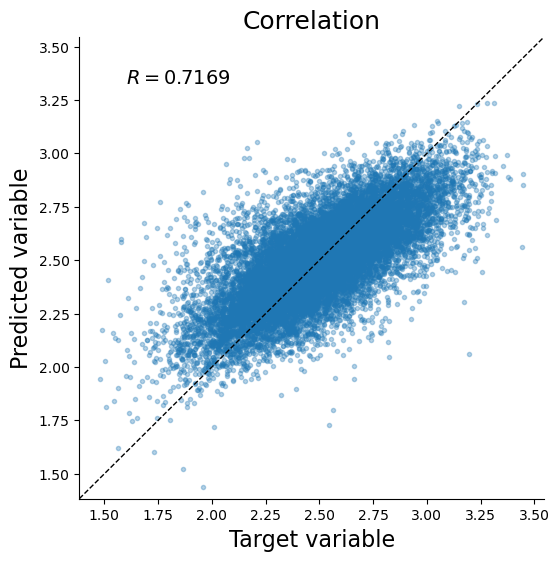

In [56]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(target_values, predicted_values, marker=".", alpha=0.33)

ax.set_xlabel("Target variable", fontsize=16)
ax.set_ylabel("Predicted variable", fontsize=16)

ax.set_title("Correlation", fontsize=18)

# Axis limits
axlim = tuple(map(max, zip(ax.get_xlim(), ax.get_ylim())))
ax.set_xlim(axlim)
ax.set_ylim(axlim)

# Diagonal line
line_x = target_values.mean()
ax.axline([line_x, line_x], slope=1, color="k", ls="--", lw=1)

ax.text(0.1, 0.9, f"$R = {R:.04f}$", fontsize=14, transform=ax.transAxes)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
fig.show()
# fig.savefig("test.svg")

---